In [21]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from typing import List, Dict
import time

# Compiling block

In [22]:
class ClogParser:
    def __init__(self, exe_path: str, args: List[str], makefile_dir: str = None):
        self.exe_path = exe_path
        self.args = args
        self.makefile_dir = makefile_dir or os.path.dirname(exe_path)

    def compile(self) -> None:
        print("🔧 Compiling with make...")
        start = time.time()
        result = subprocess.run(["make","pull"], cwd=self.makefile_dir, capture_output=True, text=True)
        end = time.time()
        if result.returncode != 0:
            print("❌ Make failed!\n", result.stderr)
            raise RuntimeError("Compilation failed.")
        print(f"✅ Compilation successful for {end - start}s.")

    def run(self):
        print("🔧 Running it...")
        start = time.time()
        result = subprocess.run([self.exe_path] + self.args, capture_output=True, text=True)
        end = time.time()
        if result.stderr:
            print("Execution stderr:\n", result.stderr)
        print(f"✅ Done running for {end - start}s.")
        return result.stderr, result.stdout

    def parse_monitoring_lines(self, logs: str) -> pd.DataFrame:
        lines = logs.splitlines()
        pattern = re.compile(r"\[MONITOR\]\s+(.*)")
        data = []

        for line in lines:
            match = pattern.search(line)
            if match:
                fields = match.group(1)
                pairs = [kv.split("=", 1) for kv in fields.split() if "=" in kv]
                entry = {k: v for k, v in pairs}
                data.append(entry)

        df = pd.DataFrame(data)

        # Coerce types (handle optional fields)
        numeric_cols = ["accuracy", "adding_time", "false_positives", "memory", "merge_time", "test_time"]
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # Rename for consistency with the example
        df = df.rename(columns={
            "scheme": "HashScheme",
            "algo": "HashAlgo",
            "adding_time": "AddOrRemoveTime",
            "test_time": "TestTime",
            "merge_time": "MergeTime",
            "filter": "Filter",
            "id": "FilterID"
        })

        return df

In [ ]:
exe = "D:/Desktop/csbf/main.exe"
args = []
make_dir = "D:/Desktop/csbf"  # your Makefile directory

parser = ClogParser(exe_path=exe, args=args, makefile_dir=make_dir)
parser.compile()
monitors, logs = parser.run()

🔧 Compiling with make...


In [ ]:
df = parser.parse_monitoring_lines(monitors)
# df.loc[66:70, 'Filter'] = 'MergableCBF'
# df.loc[46:65, 'Filter'] = 'MergeableFilter'

df.head()

,accuracy,AddOrRemoveTime,HashAlgo,false_positives,Filter,FilterID,memory,MergeTime,HashScheme,TestTime
0,0.969717,1.639647,murmur3_128,30283,OHBF,1747755400163,7760935.0,0.0,kir-mitz,3.509315
1,0.969618,3.889985,sha256,30382,OHBF,1747755404947,7760935.0,0.0,kir-mitz,8.870940
2,0.999215,2.227682,murmur3_128,785,DelBF,1747755416616,11641402.0,0.0,kir-mitz,4.628424
3,0.999180,4.389769,sha256,820,DelBF,1747755422407,11641402.0,0.0,kir-mitz,10.080225
4,0.999192,1.953221,murmur3_128,808,StdBF,1747755433961,7760935.0,0.0,kir-mitz,4.540106


# Visualization block

# Bank UC

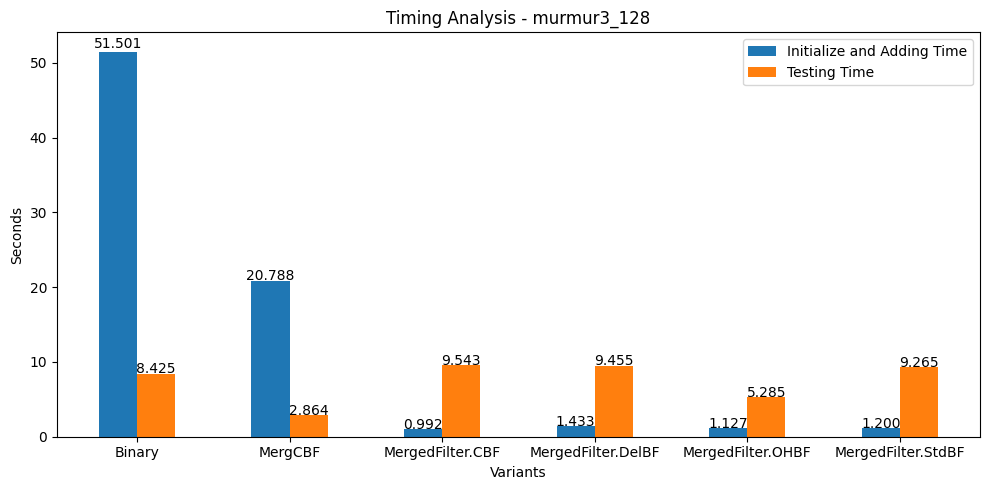

[INFO] No time data for HashAlgo = sha256
[INFO] No time data for HashAlgo = nan


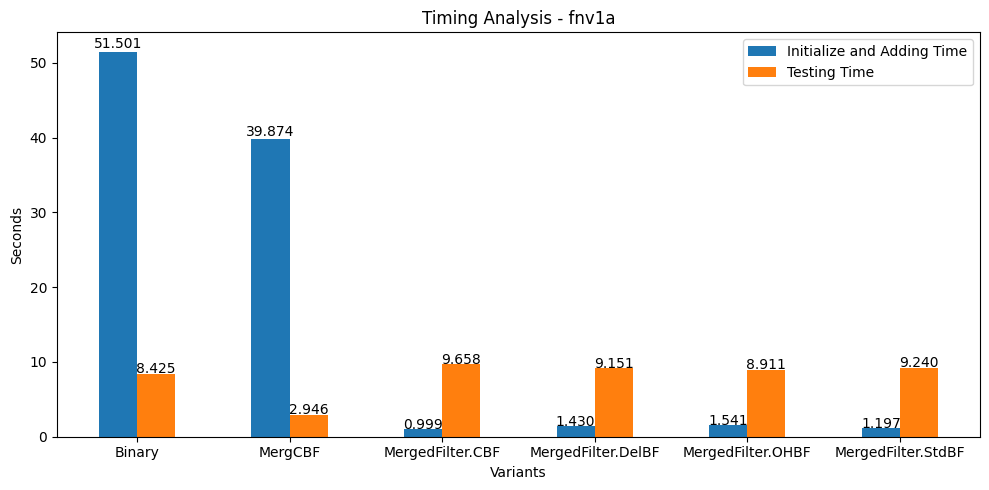

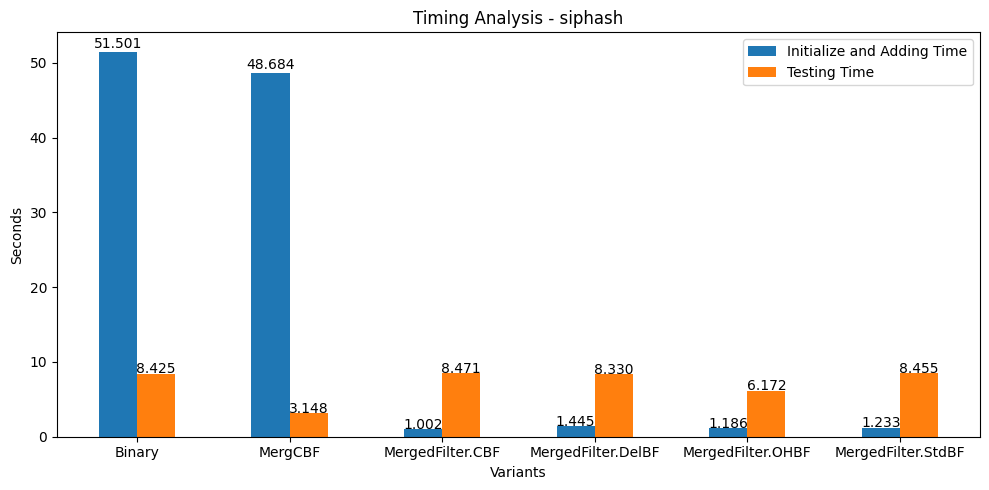

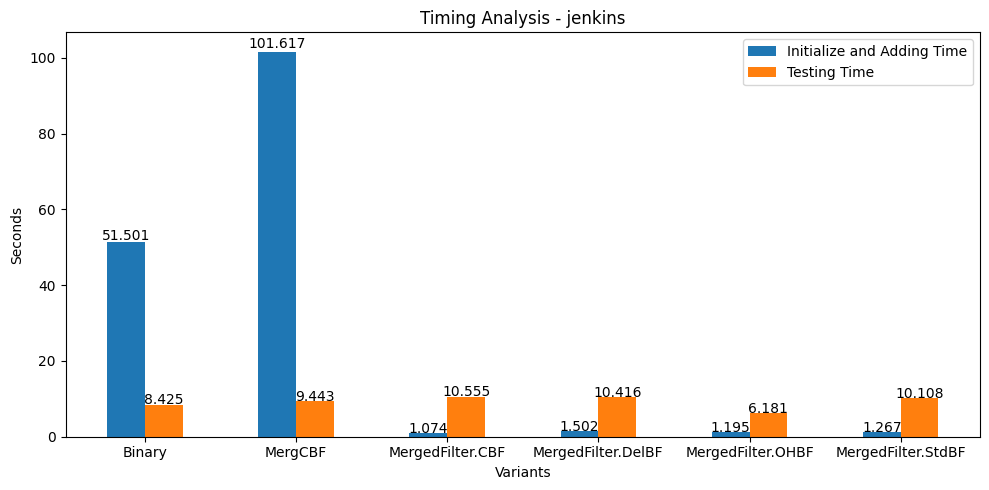

In [ ]:
class PerformanceVisualizer:
    def __init__(self, df: pd.DataFrame, prefix: str = ""):
        self.isMakingEps = True
        self.isMakingEps = False
        self.png_dpi = 1000
        self.df = df
        self.prefix = prefix
        
    def hashes(self) -> List[str]:
        # Extract unique hash schemes and algorithms
        hash_algos = self.df["HashAlgo"].unique()
        return list(hash_algos)
    
    def time_analysis_plot(self, target_filters: List[str]):
        for hash in self.hashes():
            # filtered_df = self.df[self.df["HashAlgo"] == hash]
            if not self.df.empty:
                self.time_analysis_plot_helper(hash, target_filters)

    def time_analysis_plot_helper(self, target_hash: str, target_filters: List[str]):
        # Prepare base DataFrame
        df = self.df.copy()
        # df["HashScheme"] = df["HashScheme"].fillna("unknown")
        df["HashAlgo"] = df["HashAlgo"].fillna("BinarySearch")

        # Prepare the DataFrame as in the original example
        grouped_df = (
            df.groupby(["Filter", "HashAlgo"])
            .mean(numeric_only=True)
            .reset_index()
        )
        
        # print (grouped_df['Filter'])
        mask = (grouped_df["HashAlgo"] == target_hash) | (grouped_df["HashAlgo"] == "BinarySearch")
        mask &= grouped_df["Filter"].isin(target_filters)
        scheme_df = grouped_df[mask]
        # print (scheme_df['Filter'])
        scheme_df = scheme_df[["Filter", "AddOrRemoveTime", "TestTime", "MergeTime"]]
        
        if scheme_df.shape[0] <= 1:
            print(f"[INFO] No time data for HashAlgo = {target_hash}")
            return
        
        time_perf_df = scheme_df
        variants = time_perf_df["Filter"]
        add_time = time_perf_df["AddOrRemoveTime"]
        test_time = time_perf_df["TestTime"]

        x = np.arange(len(variants))
        width = 0.25

        plt.figure(figsize=(10, 5))
        plt.bar(x - width/2, add_time, width, label="Initialize and Adding Time")
        plt.bar(x + width/2, test_time, width, label="Testing Time")

        for i, v in enumerate(add_time):
            if not np.isnan(v):
                plt.text(i - width / 2, v * 1.01, f"{v:.3f}", ha='center', fontsize=10)

        for i, v in enumerate(test_time):
            if not np.isnan(v):
                plt.text(i + width / 2, v * 1.01, f"{v:.3f}", ha='center', fontsize=10)

        plt.xlabel("Variants")
        plt.ylabel("Seconds")
        plt.xticks(x, variants)
        plt.legend()
        plt.title(f"Timing Analysis - {target_hash}")
        # plot_filename = f"time-{target_hash.replace('-', '_')}"
        plt.tight_layout()
        plt.savefig(f"./monitor/capstone-results/pdfs/{self.prefix}-time-{target_hash}.pdf")
        plt.savefig(f"./monitor/capstone-results/pngs/{self.prefix}-time-{target_hash}.png", dpi=self.png_dpi)
        if (self.isMakingEps): plt.savefig(f"./monitor/capstone-results/{self.prefix}-time-{target_hash}.eps")
        plt.show()
        
    def analyze_accuracy_plot(self, target_filters: List[str]):
        for hash in self.hashes():
            if not self.df.empty:
                self.analyze_accuracy_plot_helper(hash, target_filters)
        
    def analyze_accuracy_plot_helper(self, target_hash: str, target_filters: List[str]):
        """
        Plot Accuracy vs False Positives for a given HashAlgo (target_hash).
        Includes 'BinarySearch' as baseline. Filters are externally provided.
        """
        df = self.df.copy()
        df["HashAlgo"] = df["HashAlgo"].fillna("BinarySearch")
        df["HashScheme"] = df["HashScheme"].fillna("unknown")

        # Group by and normalize
        grouped_df = (
            df.groupby(["Filter", "HashAlgo"])
            .mean(numeric_only=True)
            .reset_index()
        )

        # Filter only rows for target_hash or BinarySearch and matching filters
        mask = (grouped_df["HashAlgo"] == target_hash) | (grouped_df["HashAlgo"] == "BinarySearch")
        mask &= grouped_df["Filter"].isin(target_filters)
        scheme_df = grouped_df[mask]

        if scheme_df.shape[0] <= 1:
            print(f"[INFO] No data found for HashAlgo = {target_hash}")
            return

        filters = scheme_df["Filter"]
        accuracy = scheme_df["accuracy"].astype(float)
        false_positive = scheme_df["false_positives"].astype(int)

        x = np.arange(len(filters))
        width = 0.25

        fig, ax1 = plt.subplots(figsize=(10, 5.3))
        axes_gap = 0.33

        # rects1 = ax1.bar(x - width / 2, accuracy, width, label='Accuracy', color='blue')
        rects1 = ax1.bar(x - axes_gap / 2, accuracy, width, label='Accuracy', color='blue')
        ax1.set_ylabel('Accuracy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        # rects2 = ax2.bar(x + width / 2, false_positive, width, label='False Positives', color='coral')
        rects2 = ax2.bar(x + axes_gap / 2, false_positive, width, label='False Positives', color='coral')
        ax2.set_ylabel('False Positives', color='coral')
        ax2.tick_params(axis='y', labelcolor='coral')

        ax1.set_xticks(x)
        ax1.set_xticklabels(filters)
        ax1.set_xlabel("Hash variants")
        
        # Auto scale
        # ax1.set_ylim(bottom=max(0.95, accuracy.min() - 0.01), top=min(1.0, accuracy.max() + 0.01))
        ax2.set_ylim(bottom=0, top=false_positive.max() * 1.2)

        def autolabel(rects, ax, fmt="{:.4f}"):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(fmt.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 1),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=10, 
                            # fontweight='bold'
                            )

        autolabel(rects1, ax1, fmt="{:.4f}")
        autolabel(rects2, ax2, fmt="{}")
        
        # Get handles and labels from both axes
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()

        # Combine and pass to legend
        ax1.legend(handles1 + handles2, labels1 + labels2, loc='center right')

        plt.title(f"Accuracy Analysis - {target_hash}")
        plt.tight_layout()
        plt.tick_params(axis='both', which='major', labelsize=6)

        # plot_filename = f"acc-{target_hash.replace('-', '_')}"
        plt.savefig(f"./monitor/capstone-results/pdfs/{self.prefix}-acc-{target_hash}.pdf")
        plt.savefig(f"./monitor/capstone-results/pngs/{self.prefix}-acc-{target_hash}.png", dpi=self.png_dpi)
        if (self.isMakingEps): plt.savefig(f"./monitor/capstone-results/{self.prefix}-acc-{target_hash}.eps")
        plt.show()

    def analyze_memory_plot(self, target_filters: List[str]):
        for hash in self.hashes():
            if not self.df.empty:
                self.analyze_memory_plot_helper(hash, target_filters)
                return
    
    def analyze_memory_plot_helper(self, target_hash: str, target_filters: List[str]):
        """
        Plot combined memory usage for BinarySearch vs Bloom Filter for each filter under the target hash algorithm.
        """
        df = self.df.copy()
        df["HashAlgo"] = df["HashAlgo"].fillna("BinarySearch")
        df["HashScheme"] = df["HashScheme"].fillna("unknown")

        # Group by Filter and HashAlgo
        grouped_df = (
            df.groupby(["Filter", "HashAlgo"])
            .mean(numeric_only=True)
            .reset_index()
        )

        # Filter for target_hash and BinarySearch
        mask = ((grouped_df["HashAlgo"] == target_hash) | (grouped_df["HashAlgo"] == "BinarySearch"))
        mask &= grouped_df["Filter"].isin(target_filters)
        mem_df = grouped_df[mask]

        if mem_df.shape[0] <= 1:
            print(f"[INFO] No memory data for HashAlgo = {target_hash}")
            return

        # Pivot to have one row per Filter, two columns: BinarySearch and target_hash
        pivot_df = mem_df.pivot(index="Filter", columns="HashAlgo", values="memory")
        pivot_df = pivot_df.fillna(0) / 1024  # Convert to KB
        pivot_df = pivot_df.reset_index()

        x = np.arange(len(pivot_df))
        width = 0.5  # Width adjusted for a single combined bar per filter

        plt.figure(figsize=(10, 5))

        # Combine the BinarySearch and target_hash memory into a single bar
        combined_mem = pivot_df["BinarySearch"] + pivot_df[target_hash]

        plt.bar(x, combined_mem, width, label=f"Used Memory ")

        for i, v in enumerate(combined_mem):
            plt.text(i, v + 0.1, f"{v:.1f}", ha="center", fontsize=10)

        # plt.title(f"Memory Analysis - {target_hash}")
        plt.xlabel("Filter")
        plt.ylabel("Memory (KBs)")
        plt.xticks(x, pivot_df["Filter"], ha="center", fontsize=10)
        plt.tight_layout()
        plt.legend()
        plt.savefig(f"./monitor/capstone-results/pdfs/{self.prefix}-mem-{target_hash}.pdf")
        plt.savefig(f"./monitor/capstone-results/pngs/{self.prefix}-mem-{target_hash}.png", dpi=self.png_dpi)
        if (self.isMakingEps): plt.savefig(f"./monitor/capstone-results/{self.prefix}-mem-{target_hash}.eps")

        # Display plot without saving as eps
        plt.show()

bank_targets = ["MergedFilter.DelBF", "MergedFilter.StdBF", "MergedFilter.CBF", "MergedFilter.OHBF", "MergCBF", "Binary"] 
visualizer = PerformanceVisualizer(df,'bank')
visualizer.time_analysis_plot(bank_targets)


### Accuracy

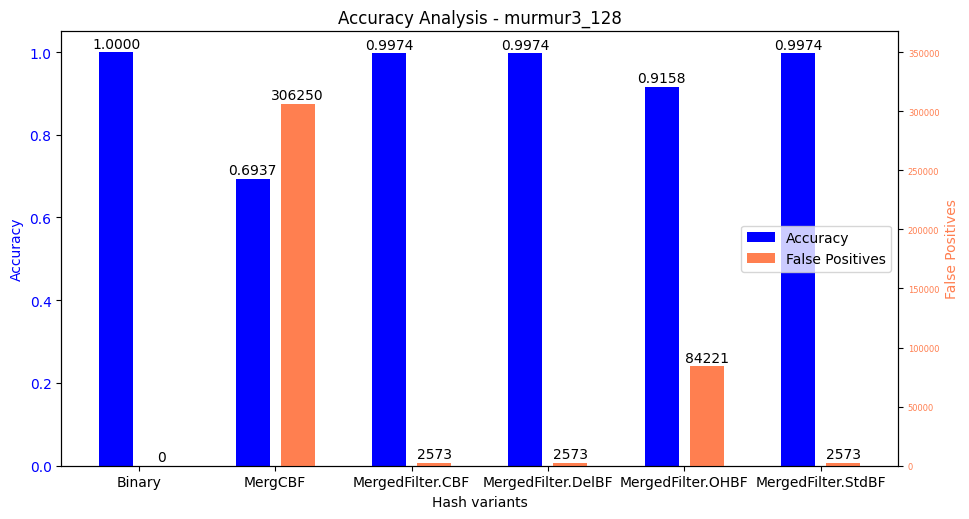

[INFO] No data found for HashAlgo = sha256
[INFO] No data found for HashAlgo = nan


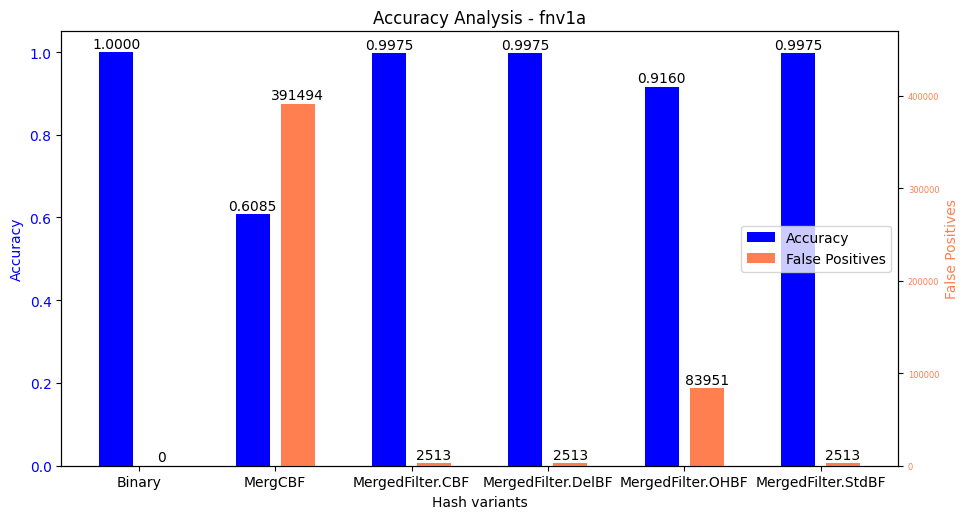

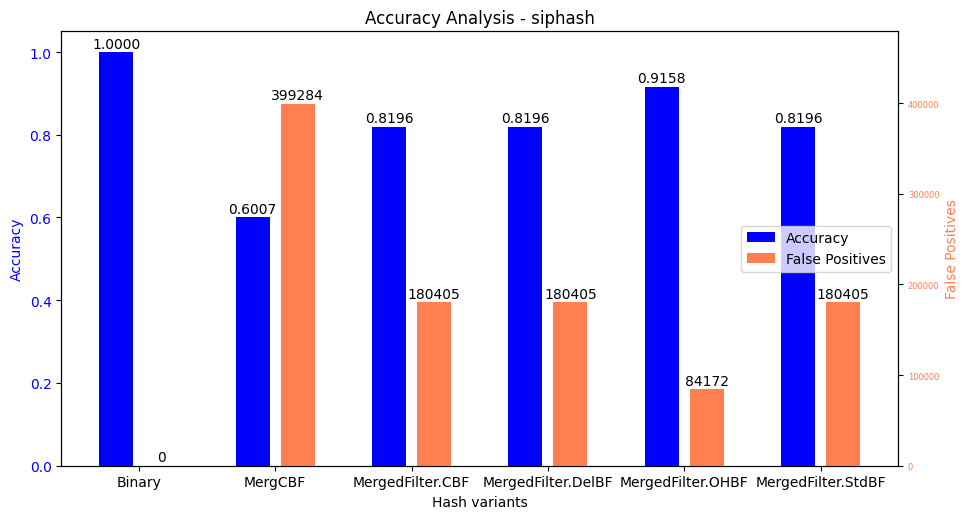

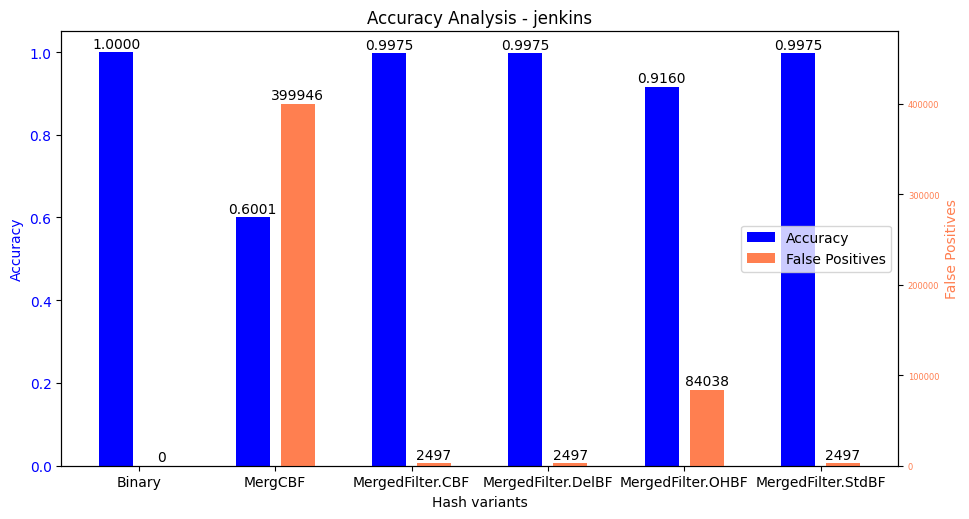

In [ ]:
visualizer.analyze_accuracy_plot(bank_targets)


### Memory

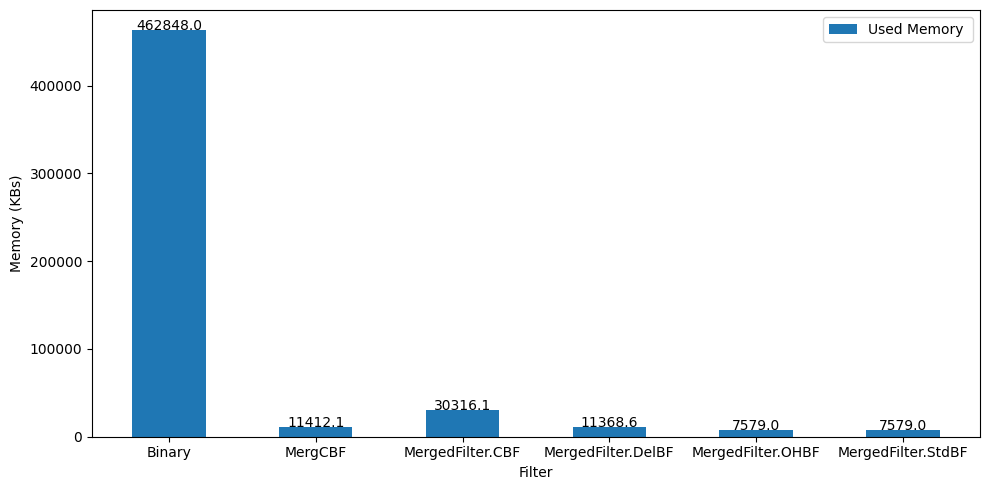

In [ ]:
visualizer.analyze_memory_plot(bank_targets)


# Bus UC

### Time

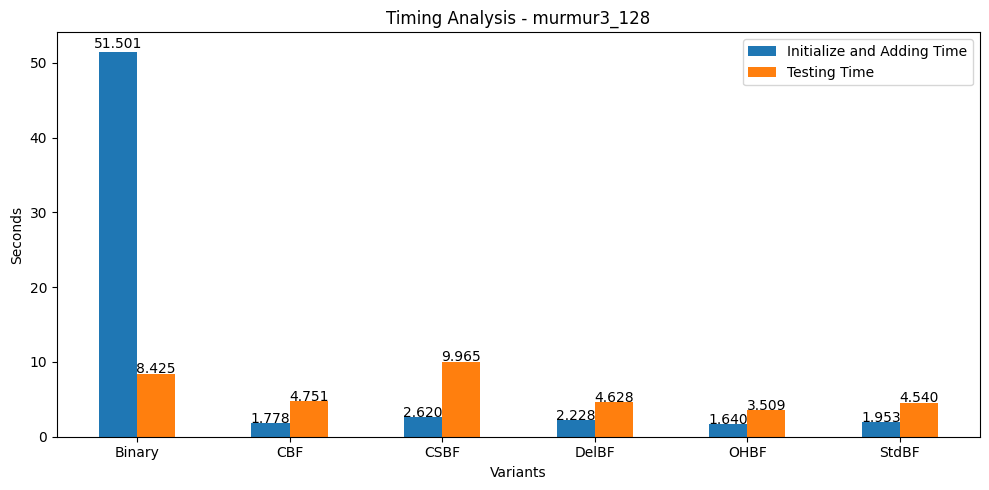

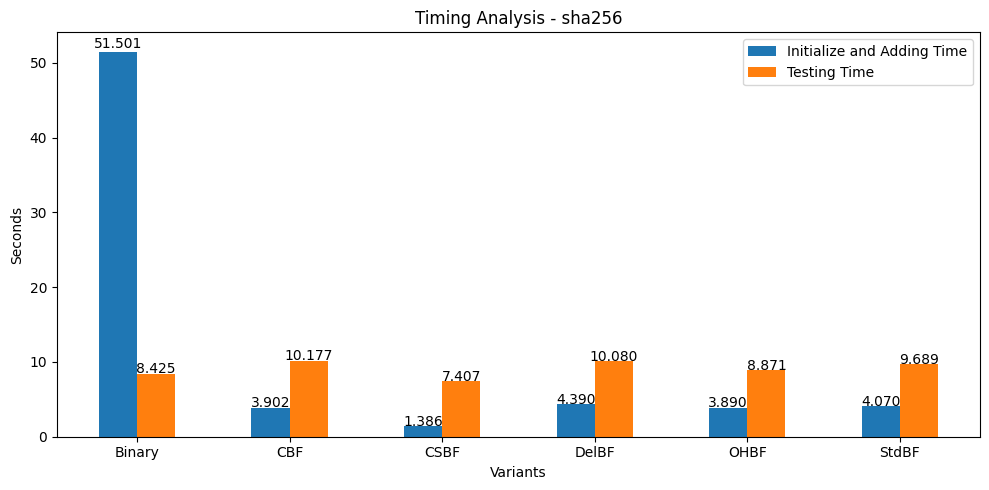

[INFO] No time data for HashAlgo = nan
[INFO] No time data for HashAlgo = fnv1a
[INFO] No time data for HashAlgo = siphash
[INFO] No time data for HashAlgo = jenkins


In [ ]:
bus_targets = [
    "OHBF",
    "DelBF",
    "StdBF",
    "CBF",
    "CSBF",
    "Binary",
]
visualizer = PerformanceVisualizer(df,'bus')
visualizer.time_analysis_plot(bus_targets)


### Accuracy 

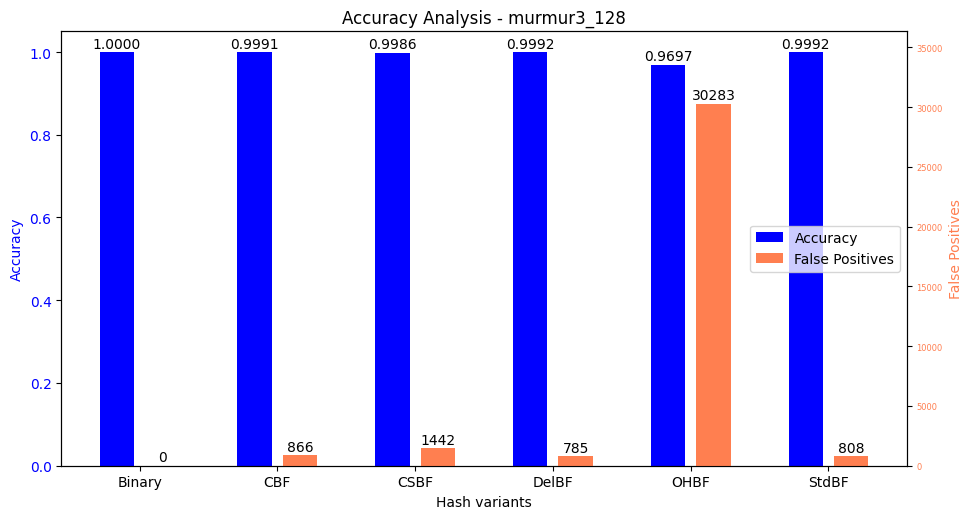

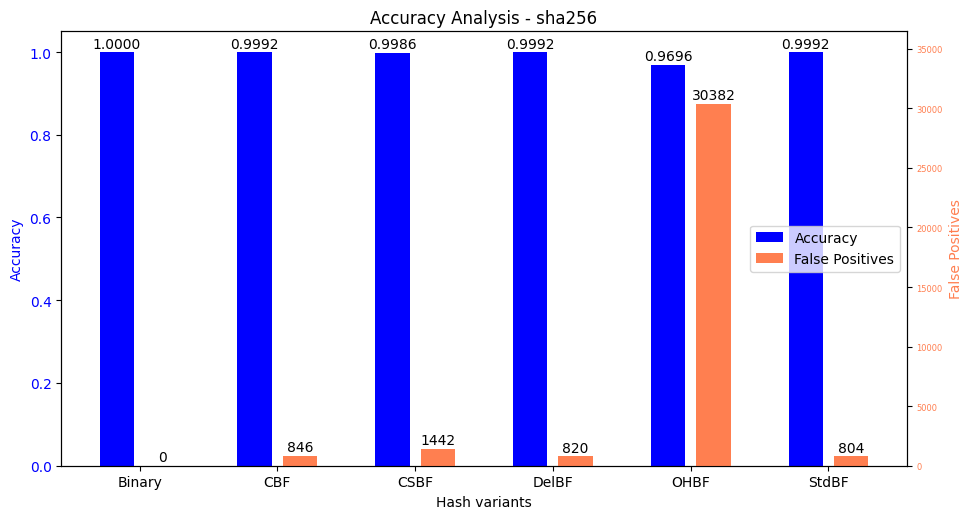

[INFO] No data found for HashAlgo = nan
[INFO] No data found for HashAlgo = fnv1a
[INFO] No data found for HashAlgo = siphash
[INFO] No data found for HashAlgo = jenkins


In [ ]:
visualizer.analyze_accuracy_plot(bus_targets)


### Memory

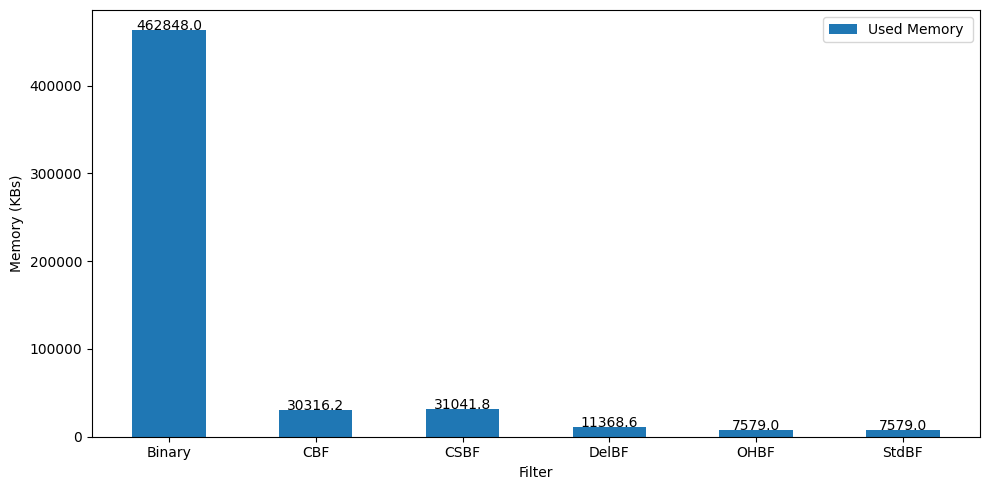

In [ ]:
visualizer.analyze_memory_plot(bus_targets)